Что такое генеративно-состязательные сети (GAN) | #31 нейросети на Python

Расширенный вариационный автоэнкодер (CVAE) | #30 нейросети на Python

Делаем вариационный автоэнкодер (VAE) в Keras | #29 нейросети на Python

In [78]:

import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.layers import Dense, SimpleRNN, Input, Embedding,LSTM, GRU, Flatten, Dropout, Bidirectional, Reshape, BatchNormalization, Lambda, concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt



In [79]:
hidden_dim = 2
num_classes = 10
batch_size = 100

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = np.reshape(x_train, (len(x_train), 28,28,1))
x_test = np.reshape(x_test, (len(x_test), 28,28,1))

y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [80]:


def dropout_and_batch(x):
    return Dropout(0.3)(BatchNormalization()(x))

In [81]:
input_img = Input(batch_shape=(batch_size, 28, 28, 1))
fl = Flatten()(input_img)
lb = Input(shape=(num_classes,))
x = concatenate([fl, lb])
x = Dense(256, activation='relu')(x)
x = dropout_and_batch(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_batch(x)

z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x) 

In [82]:
def noiseer(args):
    global z_mean, z_log_var
    z_mean, z_log_var = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.)
    return K.exp(z_log_var / 2) * N + z_mean

In [83]:
h = Lambda(noiseer, output_shape=(hidden_dim,))([z_mean, z_log_var])

In [84]:
input_dec = Input(shape=(hidden_dim,))
lb_dec = Input(shape=(num_classes,))
d = concatenate([input_dec, lb_dec])
d = Dense(128, activation='elu')(input_dec)
d = dropout_and_batch(d)
d = Dense(256, activation='elu')(input_dec)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28,28,1))(d)

encoder = keras.Model([input_img, lb], h, name='encoder')
decoder = keras.Model([input_dec, lb_dec], decoded, name='decoder')
cvae = keras.Model([input_img, lb, lb_dec], decoder([encoder([input_img, lb]), lb_dec]), name='cvae')

z_meaner = keras.Model([input_img, lb], z_mean)
tr_style = keras.Model([input_img, lb, lb_dec], decoder([z_meaner([input_img, lb]), lb_dec]), name='tr_style')


In [ ]:
def vae_loss(x,y):
    x = K.reshape(x, shape=(batch_size, 28*28))
    y = K.reshape(y, shape=(batch_size, 28*28))
    loss = K.sum(K.square(x-y), axis=-1)
    kl_loss = -0.5 * K.sum(1+z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)а
    return (loss + kl_loss)/2/28/28

cvae.compile(optimizer='adam', loss=vae_loss)

In [87]:
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, epochs=5, batch_size=batch_size, shuffle=True)


Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.0665
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0302
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0295
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0294
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0293


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


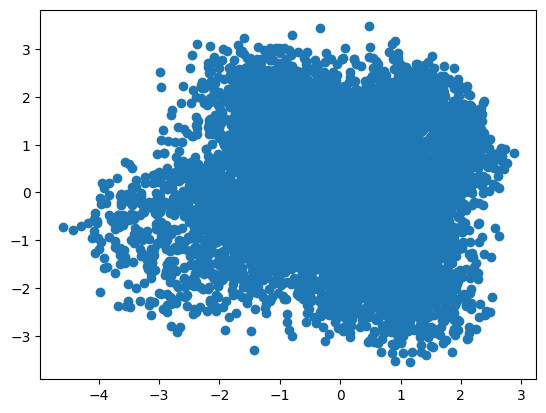

In [92]:
lb = lb_dec =y_test_cat
# h = encoder.predict([x_test, lb, lb_dec], batch_size=batch_size)
h = encoder.predict([x_test, lb], batch_size=batch_size)

plt.scatter(h[:,0], h[:,1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

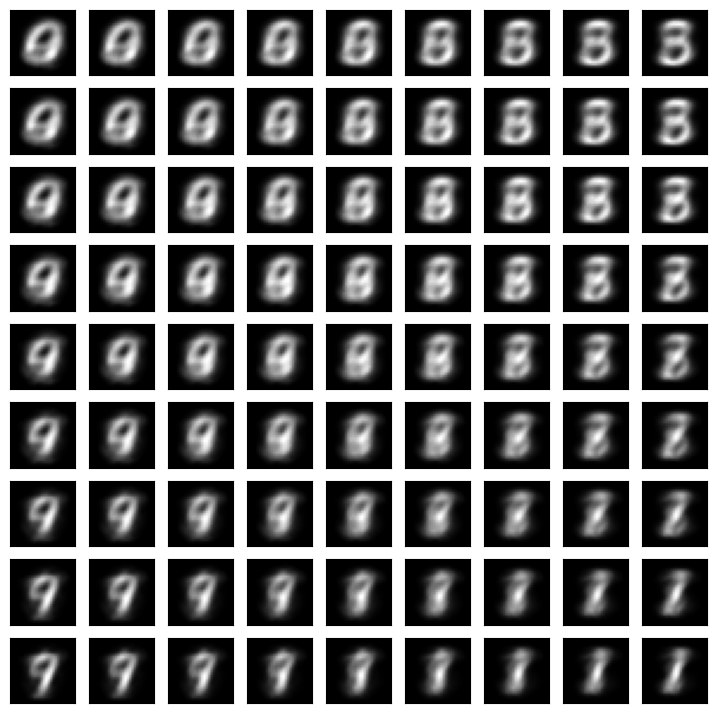

In [96]:
n = 4

total = 2*n + 1
input_lbl = np.zeros((1, num_classes))
input_lbl[0, 3]  = 1


plt.figure(figsize=(total, total))

h = np.zeros((1, hidden_dim))

num = 1

for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(total, total, num)
        num +=1
        h[0, :] = [1*i/n, 1*j/n]
        img = decoder.predict([h, input_lbl])
        plt.imshow(img.squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)